## Importing Necessary Libraries

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import ReduceLROnPlateau

## Data and Pre-processing

In [ ]:
# Path to the images
images_directory = '/kaggle/input/flickr8k/Images/'
# Path to the captions
captions_path = '/kaggle/input/flickr8k/captions.txt'

### Loading and Tokenizing the Captions

In [ ]:
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        # Lowercasing  the captions
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

# Loading the captions from the dataset
captions = load_captions(captions_path)
captions[:15:3]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

### Cleaning the captions using RegEx

In [ ]:
def clean_text(text):
    # Removing punctuation marks
    text = re.sub(r'[^\w\s]', '', text)

    # Removing numbers
    text = re.sub(r'\d+', '', text)

    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Cleaning the captions
cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

### Added padding to the captions with "start" and "end"

In [ ]:
# Image ID + \t + Caption
captions_IDs = []
for i in range(len(cleaned_captions)):
    #  Adding 'start' word and 'end' word to the captions
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)

captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

### Visualizing some of the images along with their corresponding captions (after Padding)

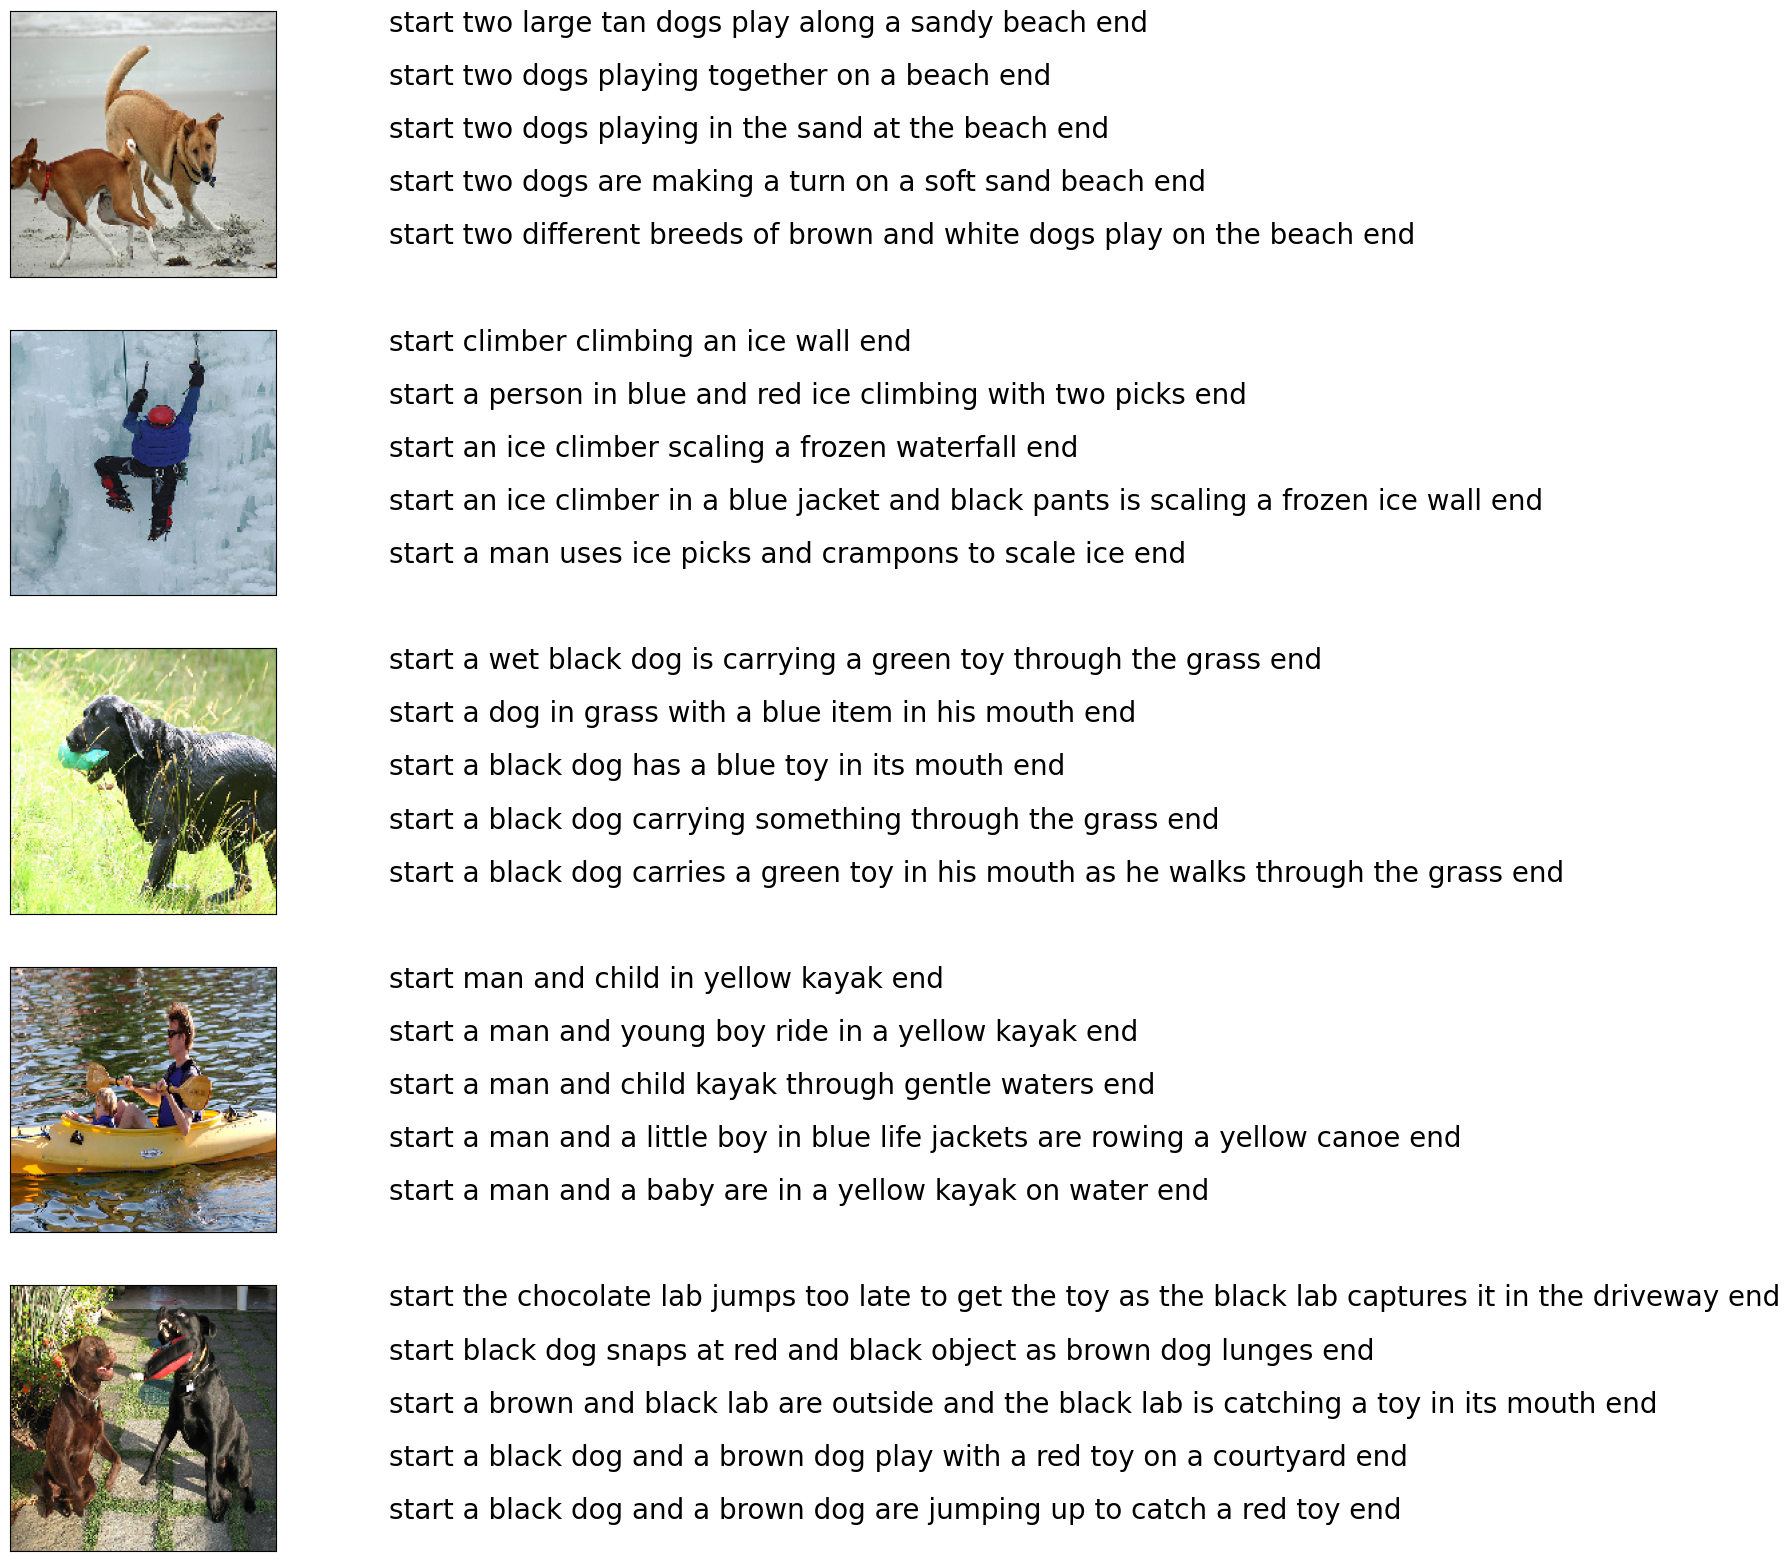

In [ ]:
def visualaization(data, num_of_images):
    # We use dictionaries to access captions of each image by its ID
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]

    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

visualaization(captions_IDs, 5)

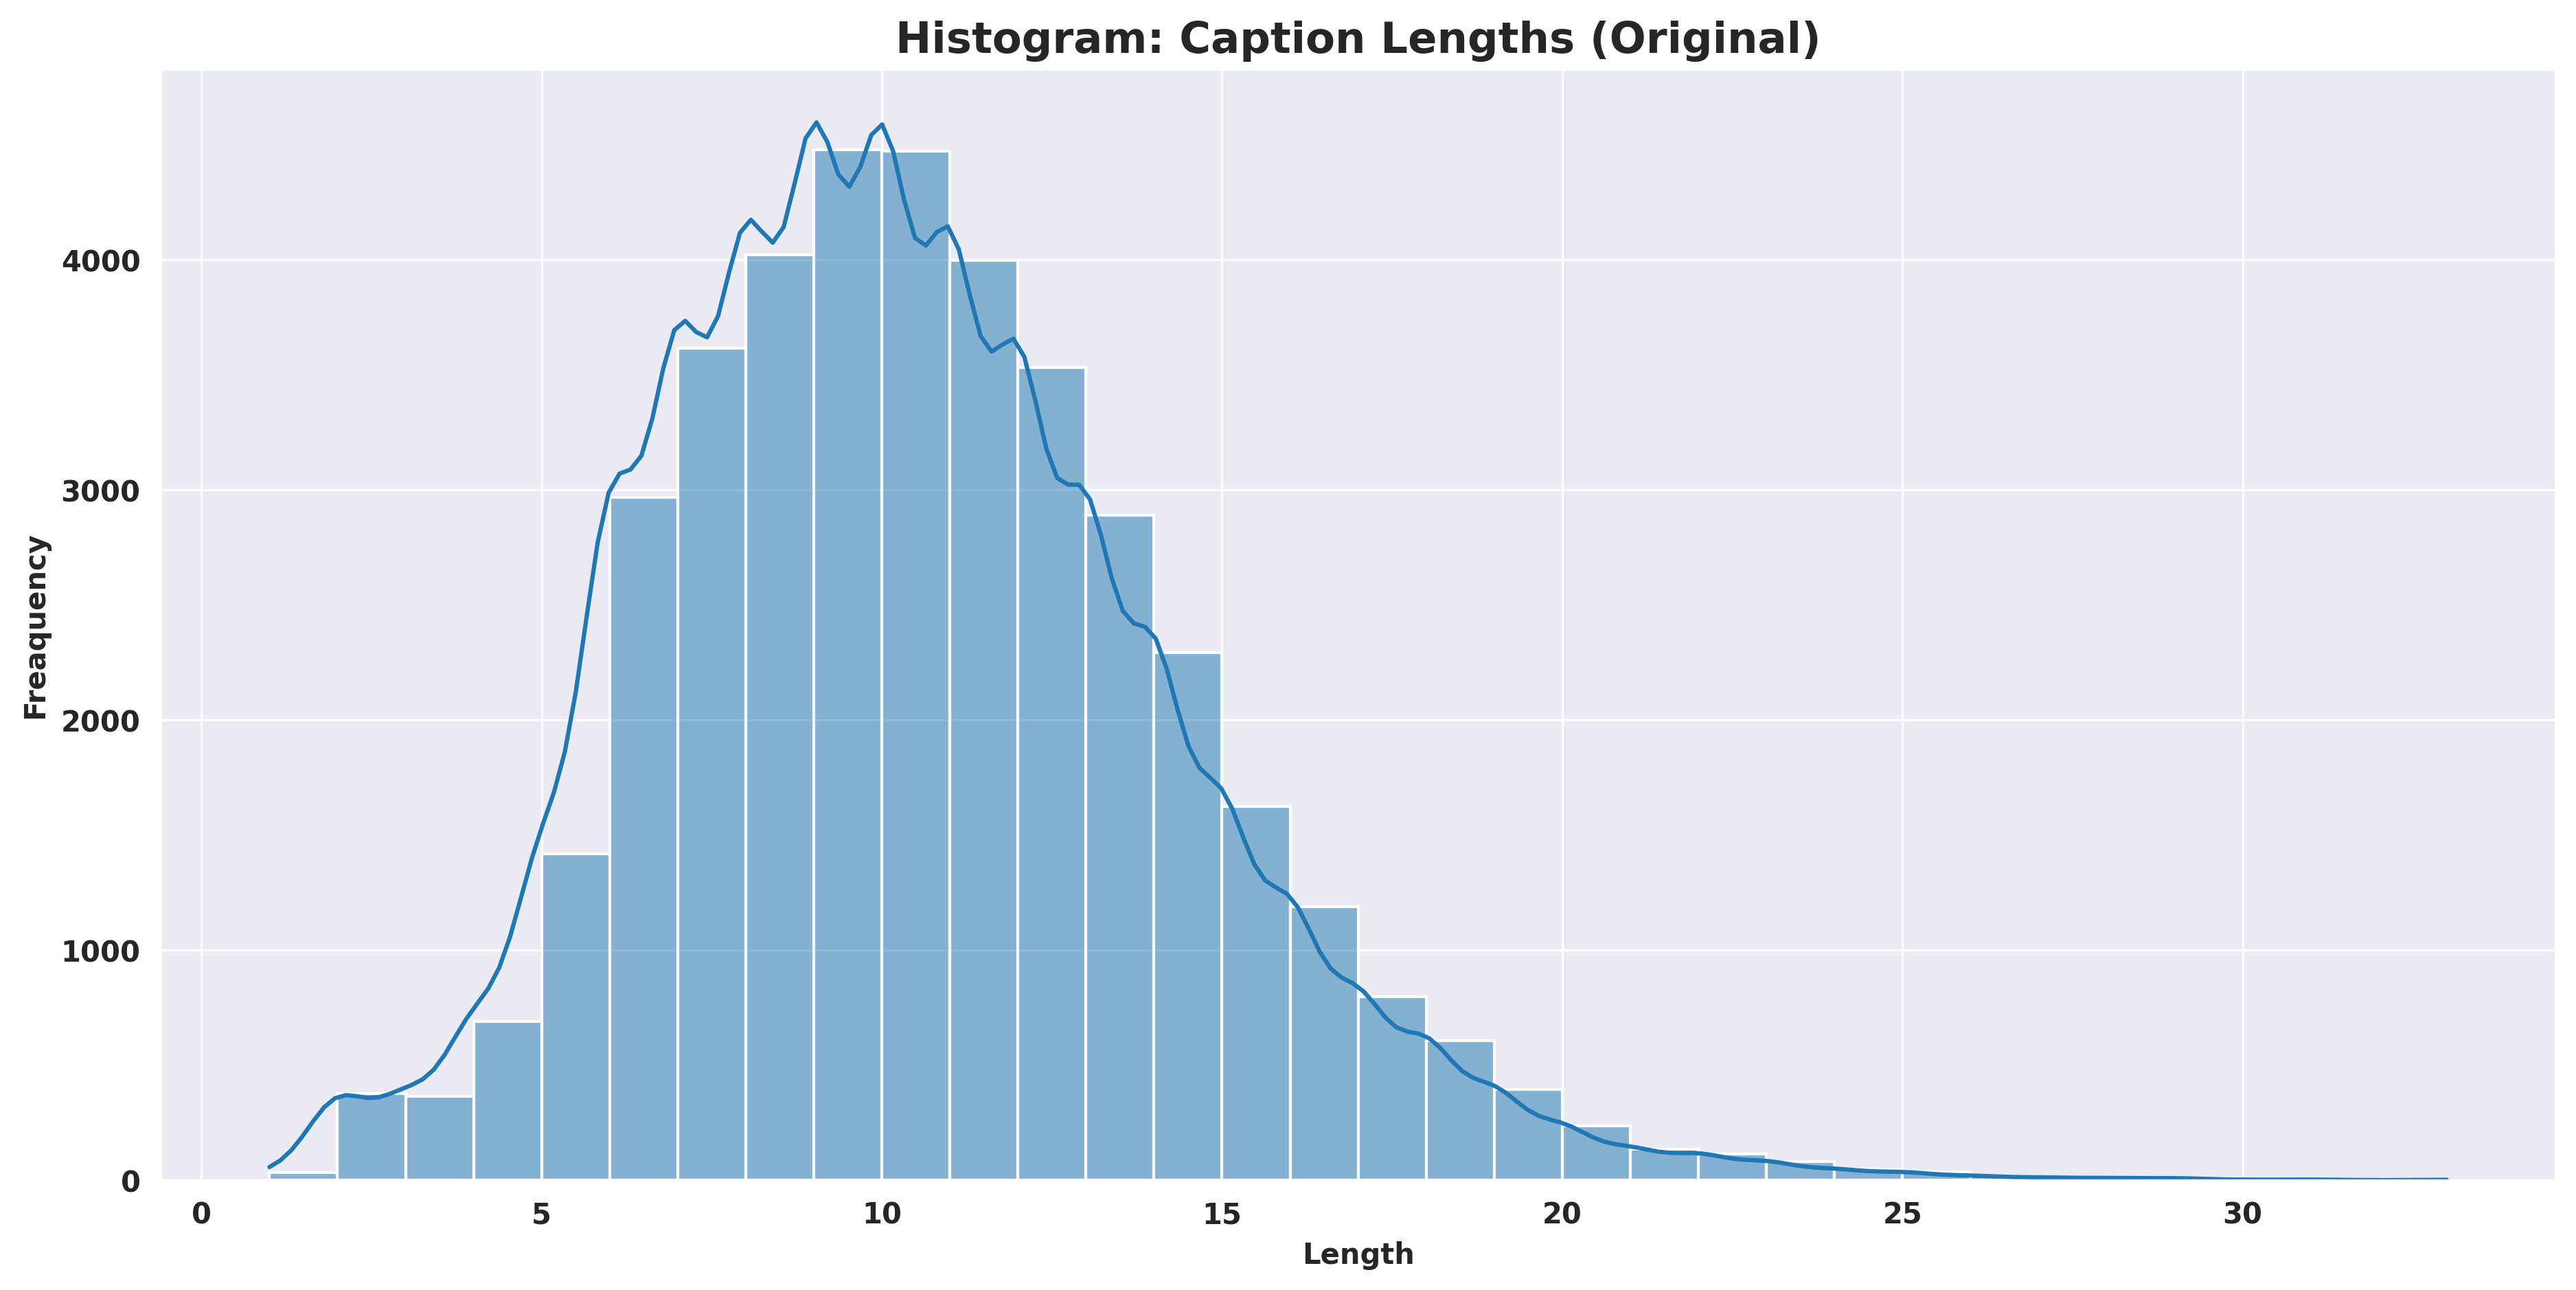

In [ ]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1)
    plt.title('Histogram: Caption Lengths (Original)', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()

captions_length(cleaned_captions)

### Tokenizing captions and Setting Vocab Size

In [ ]:
# Tokenizing the captions and creating word-to-index mapping
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8586

### Splitting the data into tain, validation and test sets

In [ ]:
# Storing all image IDs
all_image_ids = os.listdir(images_directory)

# Splitting image IDs
train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')

    if image_id in train_image_ids:
        train_captions.append(caption)

    elif image_id in val_image_ids:
        val_captions.append(caption)

    elif image_id in test_image_ids:
        test_captions.append(caption)

    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1001773457_577c3a7d70.jpg\tstart a black dog and a spotted dog are fighting end\n',
 '1042590306_95dea0916c.jpg\tstart a man and woman pose for the camera while another man looks on end\n',
 6877.0,
 1092.0,
 122.0)

## Extracting Image features using The InceptionV3 model

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

# Loading the pre-trained InceptionV3 model
inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

96112376/96112376 [==============================] - 3s 0us/step


### Image feature extraction: Train, Validation and Test images

In [ ]:
train_image_features, val_image_features, test_image_features = {}, {}, {}  # A Dictionary to store image features with their corresponding IDs
tr, va, tt = 0, 0, 0
for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    image_features = extract_image_features(inception_v3_model, image_path) # Extracting features

    if image_id in train_image_ids:
        tr += 1
        train_image_features[image_id] = image_features.flatten()  # Flattening the features
        print("Train image ",tr, "is done")

    elif image_id in val_image_ids:
        va += 1
        val_image_features[image_id] = image_features.flatten()  # Flattening the features
        print("Validation image ",va, "is done")

    elif image_id in test_image_ids:
        tt += 1
        test_image_features[image_id] = image_features.flatten()  # Flattening the features
        print("Test image ",tt, "is done")

    else:
        print('Unknown image ID !')

## Data Generation: To optimize input

In [ ]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0] # Tokenizing the caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            yield [np.array(X_images), np.array(X_captions)], np.array(y)


# Defining the maximum length of captions
max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

# Defining the CNN output dimension (size of feature vector from InceptionV3)
cnn_output_dim = inception_v3_model.output_shape[1] # 2048

# Defining batch size
batch_size_train = 270
batch_size_val = 150

# Creating data generators for training and validation
train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

In [ ]:
# Checking shapes
sample_batch = next(train_data_generator)
print("Training sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)
print('=========================')
sample_batch = next(val_data_generator)
print("Validation sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)

Training sample batch shapes:
X_images: (3230, 2048)
X_captions: (3230, 34)
y: (3230, 8586)
Validation sample batch shapes:
X_images: (1676, 2048)
X_captions: (1676, 34)
y: (1676, 8586)


## Model 1: LSTM for Image Captioning

> ### **Encoder** (image features)
> * Input Layer
> * Batch Normalization Layer
> * Dense Layer
> * Batch Normalization Layer

> ### **Decoder** (captions)
> * Input Layer
> * Embedding Layer
> * **LSTM** Layer

> ### **Output**
> * Add Layer (Encoder output + Decoder output)
> * Dense Layer + ReLU activation function
> * Dense Layer + Softmax activation function

In [ ]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    # Encoder Model
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)

    # Decoder Model
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)

    # Output
    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    # Returning The Model
    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model

# Building the model
caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()

Model: "Image_Captioning"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Features_Input (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, 2048)        8192        ['Features_Input[0][0]']         
 ormalization)                                                                                    
                                                                                                  
 Sequence_Input (InputLayer)    [(None, 34)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['batch_normalizat

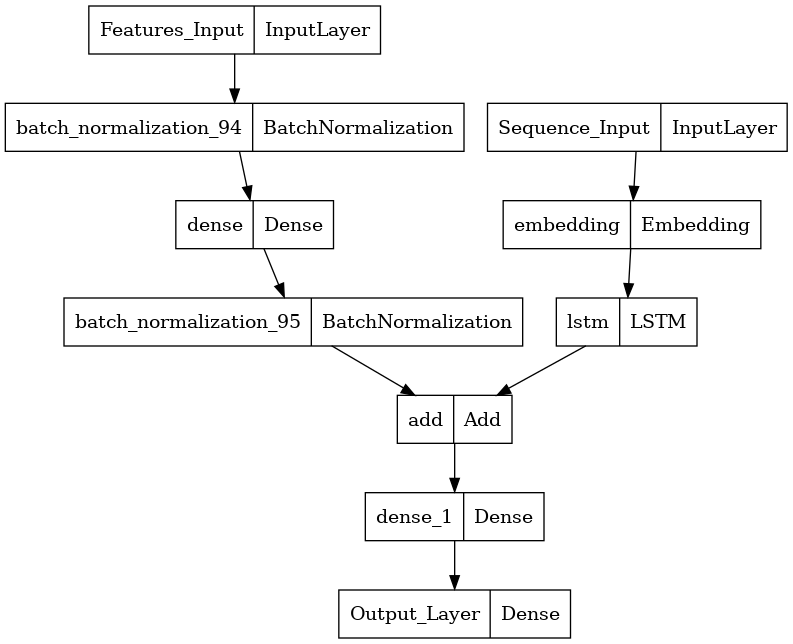

In [ ]:
plot_model(caption_model)

## Training the model - LSTM
##### **Training** will **stop** if there is **no improvement** in the **validation loss** for **3 consecutive epochs**.

In [ ]:
# Defining early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return lr * tf.math.exp(-0.6)

# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_captions) // batch_size_val,
                        epochs=15, callbacks=[early_stopping, lr_schedule])

Epoch 1/15
127/127 [==============================] - 56s 393ms/step - loss: 4.5266 - val_loss: 3.7678 - lr: 0.0055
Epoch 2/15
127/127 [==============================] - 43s 336ms/step - loss: 3.2888 - val_loss: 3.3709 - lr: 0.0030
Epoch 3/15
127/127 [==============================] - 42s 335ms/step - loss: 2.9047 - val_loss: 3.2622 - lr: 0.0017
Epoch 4/15
127/127 [==============================] - 42s 333ms/step - loss: 2.6887 - val_loss: 3.2313 - lr: 9.0718e-04
Epoch 5/15
127/127 [==============================] - 42s 333ms/step - loss: 2.5539 - val_loss: 3.2289 - lr: 4.9787e-04
Epoch 6/15
127/127 [==============================] - 42s 331ms/step - loss: 2.4723 - val_loss: 3.2259 - lr: 2.7324e-04
Epoch 7/15
127/127 [==============================] - 42s 335ms/step - loss: 2.4226 - val_loss: 3.2287 - lr: 1.4996e-04
Epoch 8/15
127/127 [==============================] - 42s 333ms/step - loss: 2.3945 - val_loss: 3.2323 - lr: 8.2297e-05
Epoch 9/15
127/127 [==============================] 

### Visualizing the model performance

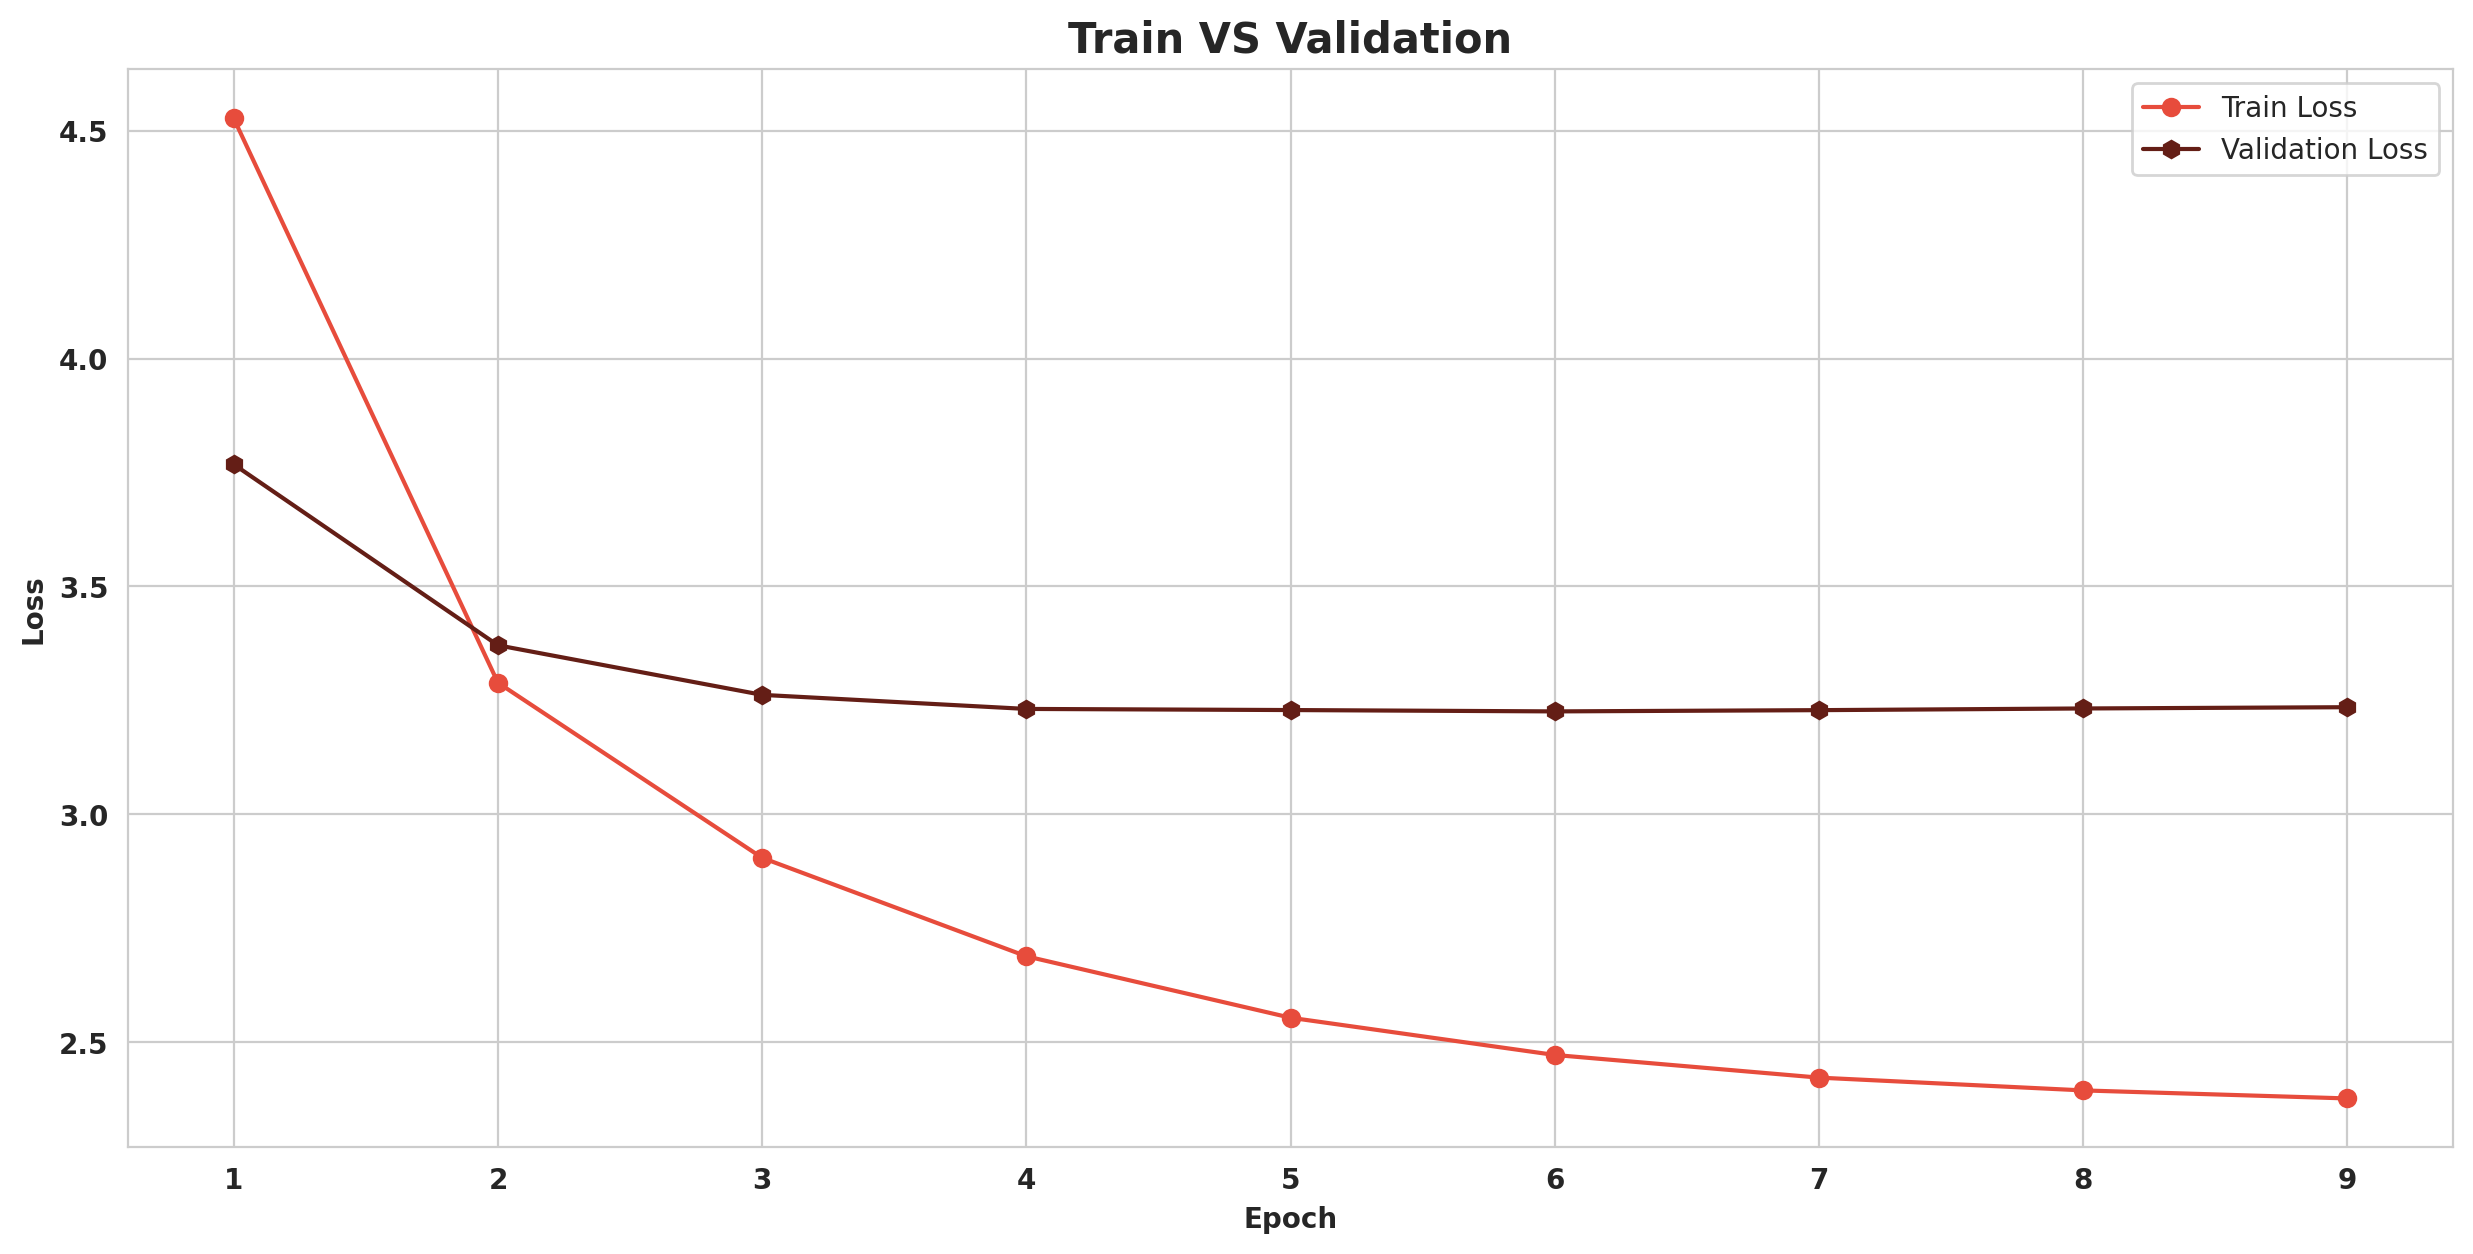

In [ ]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

## Prediction and Model evaluation - LSTM
> ##### Caption Generation: At each step, the model processes the image features alongside the previously generated words (starting with a "start" token at the first step) to predict the probability distribution for the next word

> ##### Greedy algorithm: To determine the best caption, the greedy algorithm selects the most likely word at each step and adds it to the generated caption. This process continues until the "end" token is produced or the maximum sequence length is exceeded

> ##### Beam Search is an alternative method for caption selection. It keeps track of a set of candidate captions (hypotheses) at each step. For every hypothesis, the model predicts the next word, and the top k candidates (based on their probabilities) are retained. The process stops when the "end" token is reached or the maximum sequence length is achieved.

> ##### Caption quality is assessed using the BLEU score

### Greedy Caption Generator - LSTM

In [ ]:
def greedy_generator(image_features): # A function to generate captions
    # Each caption is started with the word 'start'
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        # Adding the predicted word to the sequence
        in_text += ' ' + word
        # When the model returns the word 'end' (which is the end word), the generating loop must be stopped
        if word == 'end':
            break

    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')

    return in_text

### Beam Search Generator - LSTM

In [ ]:
def beam_search_generator(image_features, K_beams = 3, log = False):
    start = [tokenizer.word_index['start']]

    start_word = [[start, 0.0]]

    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            # Sequence of most probable words based on the previous steps
            sequence  = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1,max_caption_length))

            preds = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)

            # Sorting predictions by the probability and taking the last K_beams items.
            word_preds = np.argsort(preds[0])[-K_beams:]

            # Getting the top <K_beams>(n) predictions and creating a
            #                              new list so as to put them via the model again.
            for w in word_preds:

                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]

    start_word = start_word[-1][0]
    captions_ = [tokenizer.index_word[i] for i in start_word]

    final_caption = []

    for i in captions_:
        if i != 'end':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

## BLUE score Calculations - Used for both models

In [ ]:
# Calculates BLEU score of predictions
def BLEU_score(actual, greedy, beam_search):
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))
    score_BS_1 = corpus_bleu(actual, beam_search, weights=(0.3, 0.3, 0.3, 0))
    score_BS_2 = corpus_bleu(actual, beam_search, weights=(0.25, 0.25, 0.25, 0.25))

    return [
        (f'BLEU-2 Greedy: {round(score_BS_2, 5)}'),
        (f'BLEU-1 Greedy: {round(score_BS_1, 5)}'),
        (f'Greedy: {greedy[0]}'),
        (f'BLEU-2 Beam Search: {round(score_greedy_2, 5)}'),
        (f'BLEU-1 Beam Search: {round(score_greedy_1, 5)}'),
        (f'Beam Search:  {beam_search[0]}')
    ]

## Visualisation of Predictions - Used for both models

In [ ]:
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images):
    keys = list(data.keys()) # List of all test images
    images = [np.random.choice(keys) for i in range(num_of_images)] # Randomly selected images

    count = 1
    fig = plt.figure(figsize=(6,20))
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("start ", "") for x in actual_cap] # Removing the start token
        actual_cap = [x.replace(" end", "") for x in actual_cap] # Removing the end token

        # Generating captions
        greedy_cap = greedy_caps[filename]
        beamS_cap = beamS_generator(test_image_features[filename])

        # Getting the bleu score
        caps_with_score = evaluator(actual_cap, [greedy_cap]*(len(actual_cap)), [beamS_cap]*(len(actual_cap)))

        image_load = load_img(images_directory+filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()

## Visualizing some of the test images along with the generated Caption - LSTM

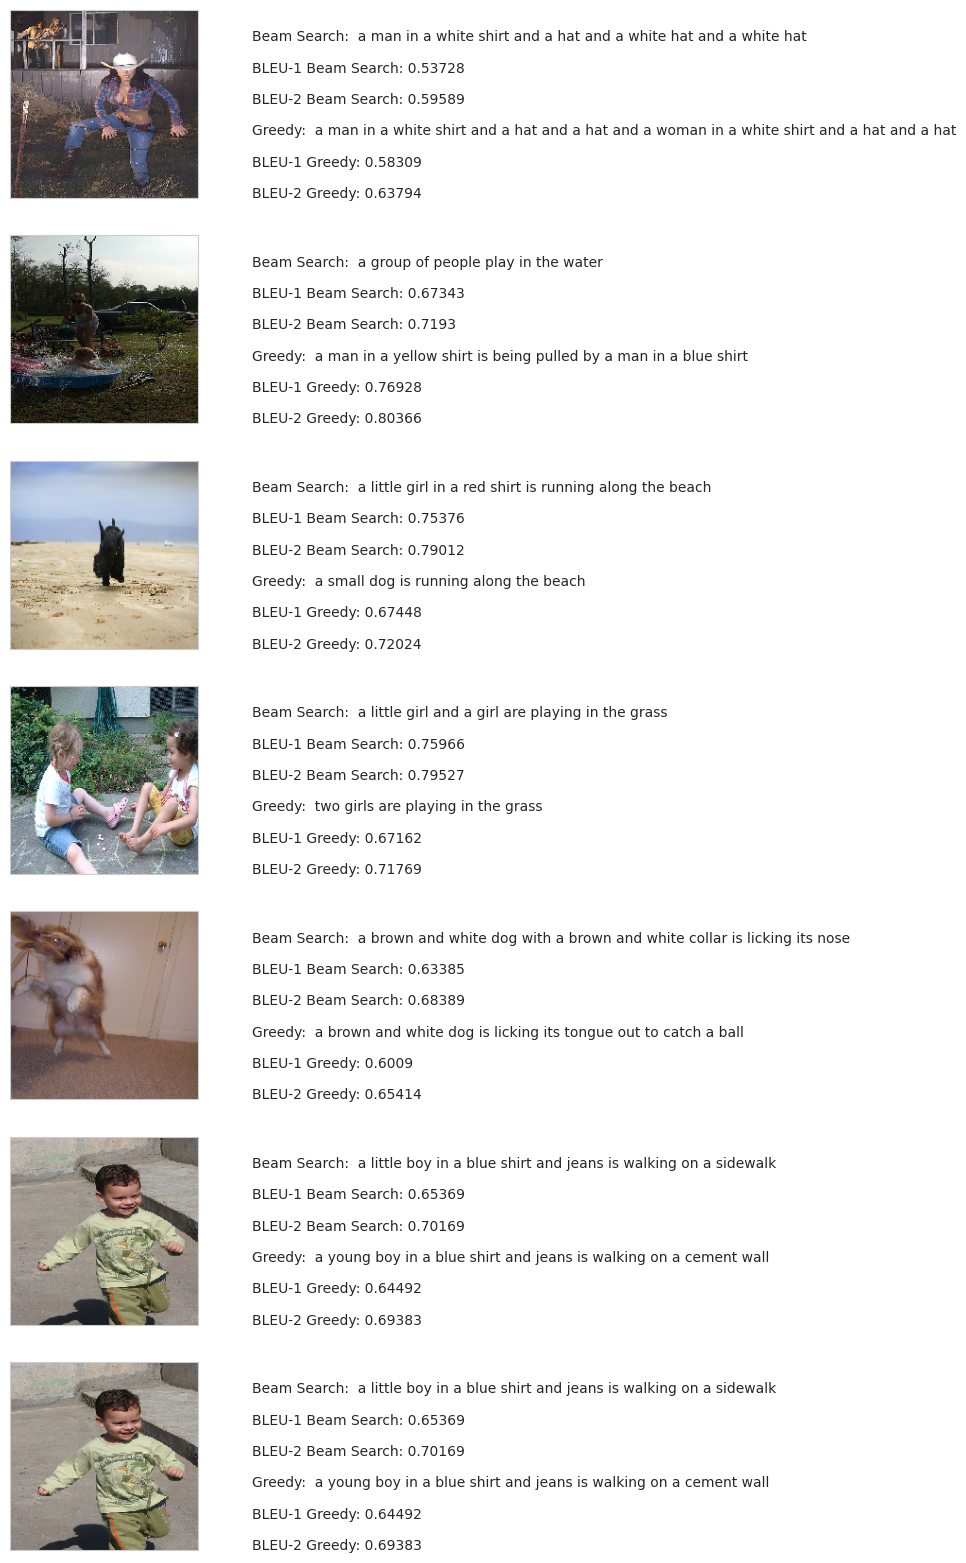

In [ ]:
# A dictionary to access actual captions of each image by its ID
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

# Generating captions
generated_captions = {}

for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap

visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 7)

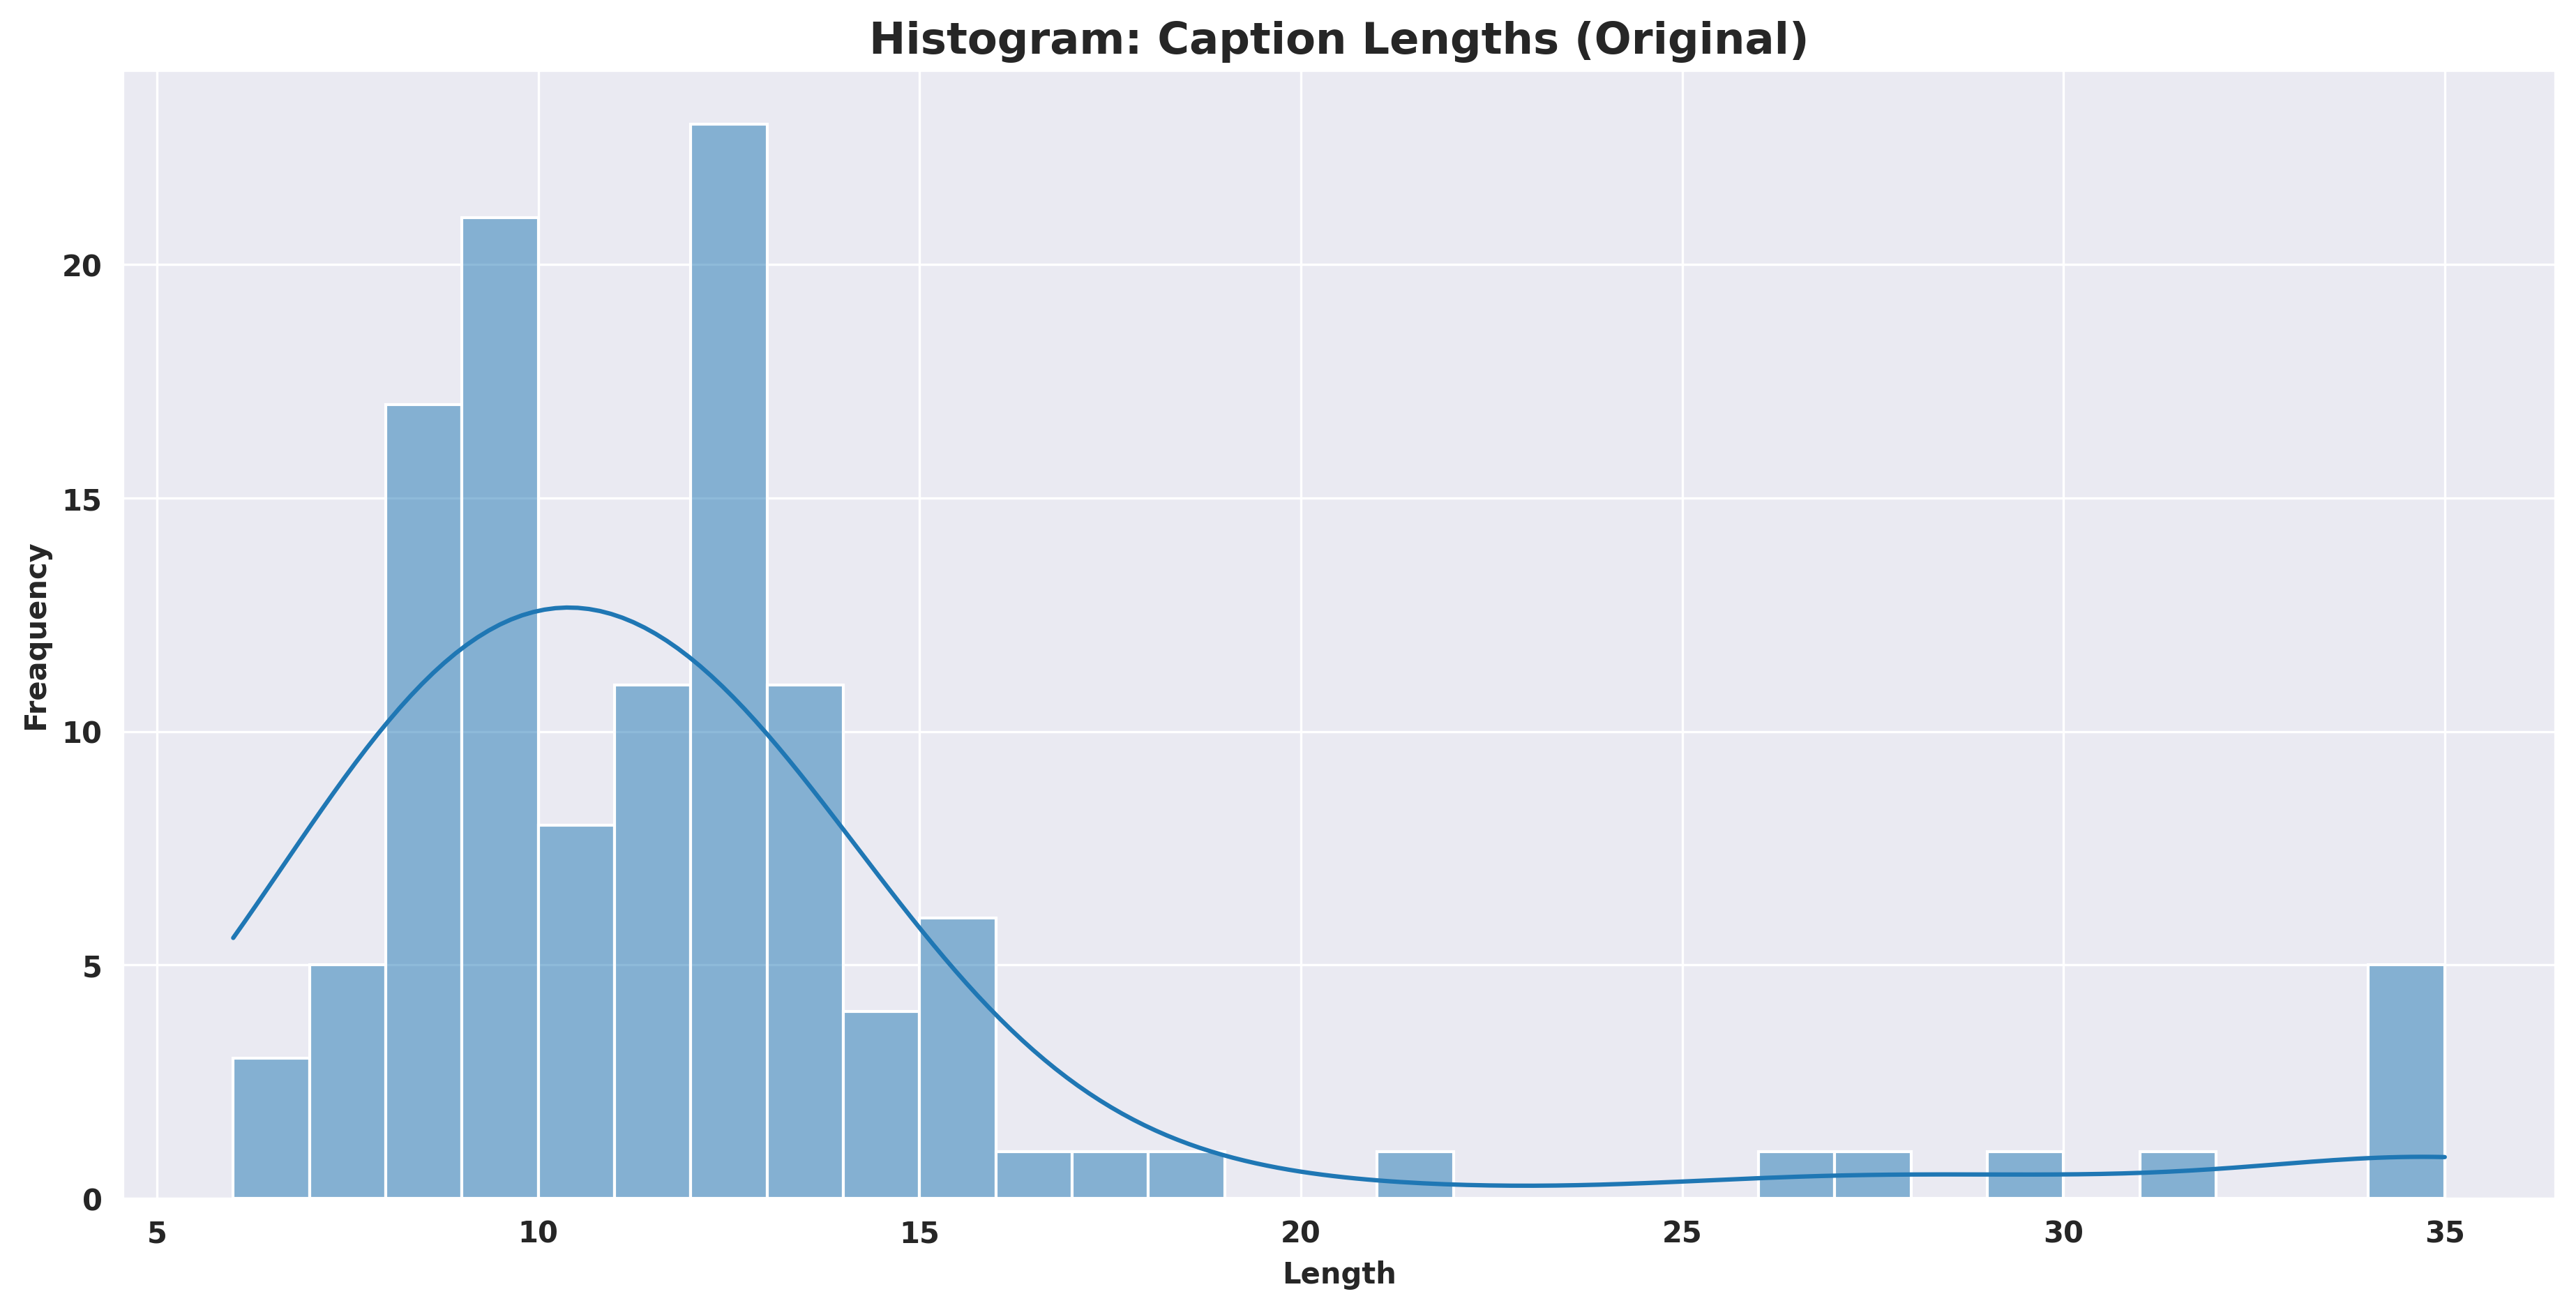

In [ ]:
captions_length(list(generated_captions.values()))

## Model 2: GRU for Image Captioning

> ### **Encoder** (image features)
> * Input Layer
> * Batch Normalization Layer
> * Dense Layer
> * Batch Normalization Layer

> ### **Decoder** (captions)
> * Input Layer
> * Embedding Layer
> * **GRU** Layer

> ### **Output**
> * Add Layer (Encoder output + Decoder output)
> * Dense Layer + ReLU activation function
> * Dense Layer + Softmax activation function

In [ ]:
def build_gru_model(vocab_size, max_caption_length, cnn_output_dim):
    # Image Encoder
    input_image = Input(shape=(cnn_output_dim,), name='Image_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1)
    fe3 = BatchNormalization()(fe2)

    # Caption Decoder
    input_caption = Input(shape=(max_caption_length,), name='Caption_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = GRU(256, return_sequences=False)(se1)

    # Combining image and caption features
    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[input_image, input_caption], outputs=outputs)
    return model

In [ ]:
# Initialize the model
gru_model = build_gru_model(vocab_size, max_caption_length, cnn_output_dim)

# Compile with optimizer and loss
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
gru_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.00001
)

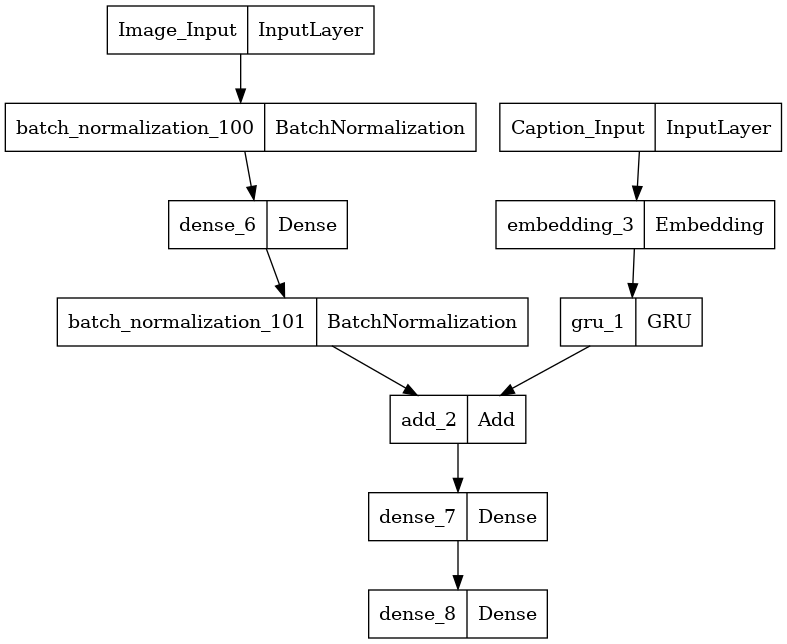

In [ ]:
plot_model(gru_model)

## Training the model - GRU
##### **Training** will **stop** if there is **no improvement** in the **validation loss** for **3 consecutive epochs**.

In [ ]:
# Using the same data generators defined earlier
gru_history = gru_model.fit(
    train_data_generator,
    steps_per_epoch=len(train_captions) // batch_size_train,
    validation_data=val_data_generator,
    validation_steps=len(val_captions) // batch_size_val,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/15
127/127 [==============================] - 46s 361ms/step - loss: 5.2376 - val_loss: 4.4789 - lr: 0.0010
Epoch 2/15
127/127 [==============================] - 42s 333ms/step - loss: 3.8278 - val_loss: 3.6099 - lr: 0.0010
Epoch 3/15
127/127 [==============================] - 42s 332ms/step - loss: 3.2173 - val_loss: 3.3669 - lr: 0.0010
Epoch 4/15
127/127 [==============================] - 42s 334ms/step - loss: 2.8693 - val_loss: 3.2965 - lr: 0.0010
Epoch 5/15
127/127 [==============================] - 42s 334ms/step - loss: 2.5977 - val_loss: 3.2993 - lr: 0.0010
Epoch 6/15
127/127 [==============================] - 42s 334ms/step - loss: 2.3749 - val_loss: 3.3528 - lr: 0.0010
Epoch 7/15
127/127 [==============================] - 42s 333ms/step - loss: 2.1466 - val_loss: 3.2939 - lr: 2.0000e-04
Epoch 8/15
127/127 [==============================] - 42s 335ms/step - loss: 2.0712 - val_loss: 3.3127 - lr: 2.0000e-04
Epoch 9/15
127/127 [==============================] - 42s 334ms/

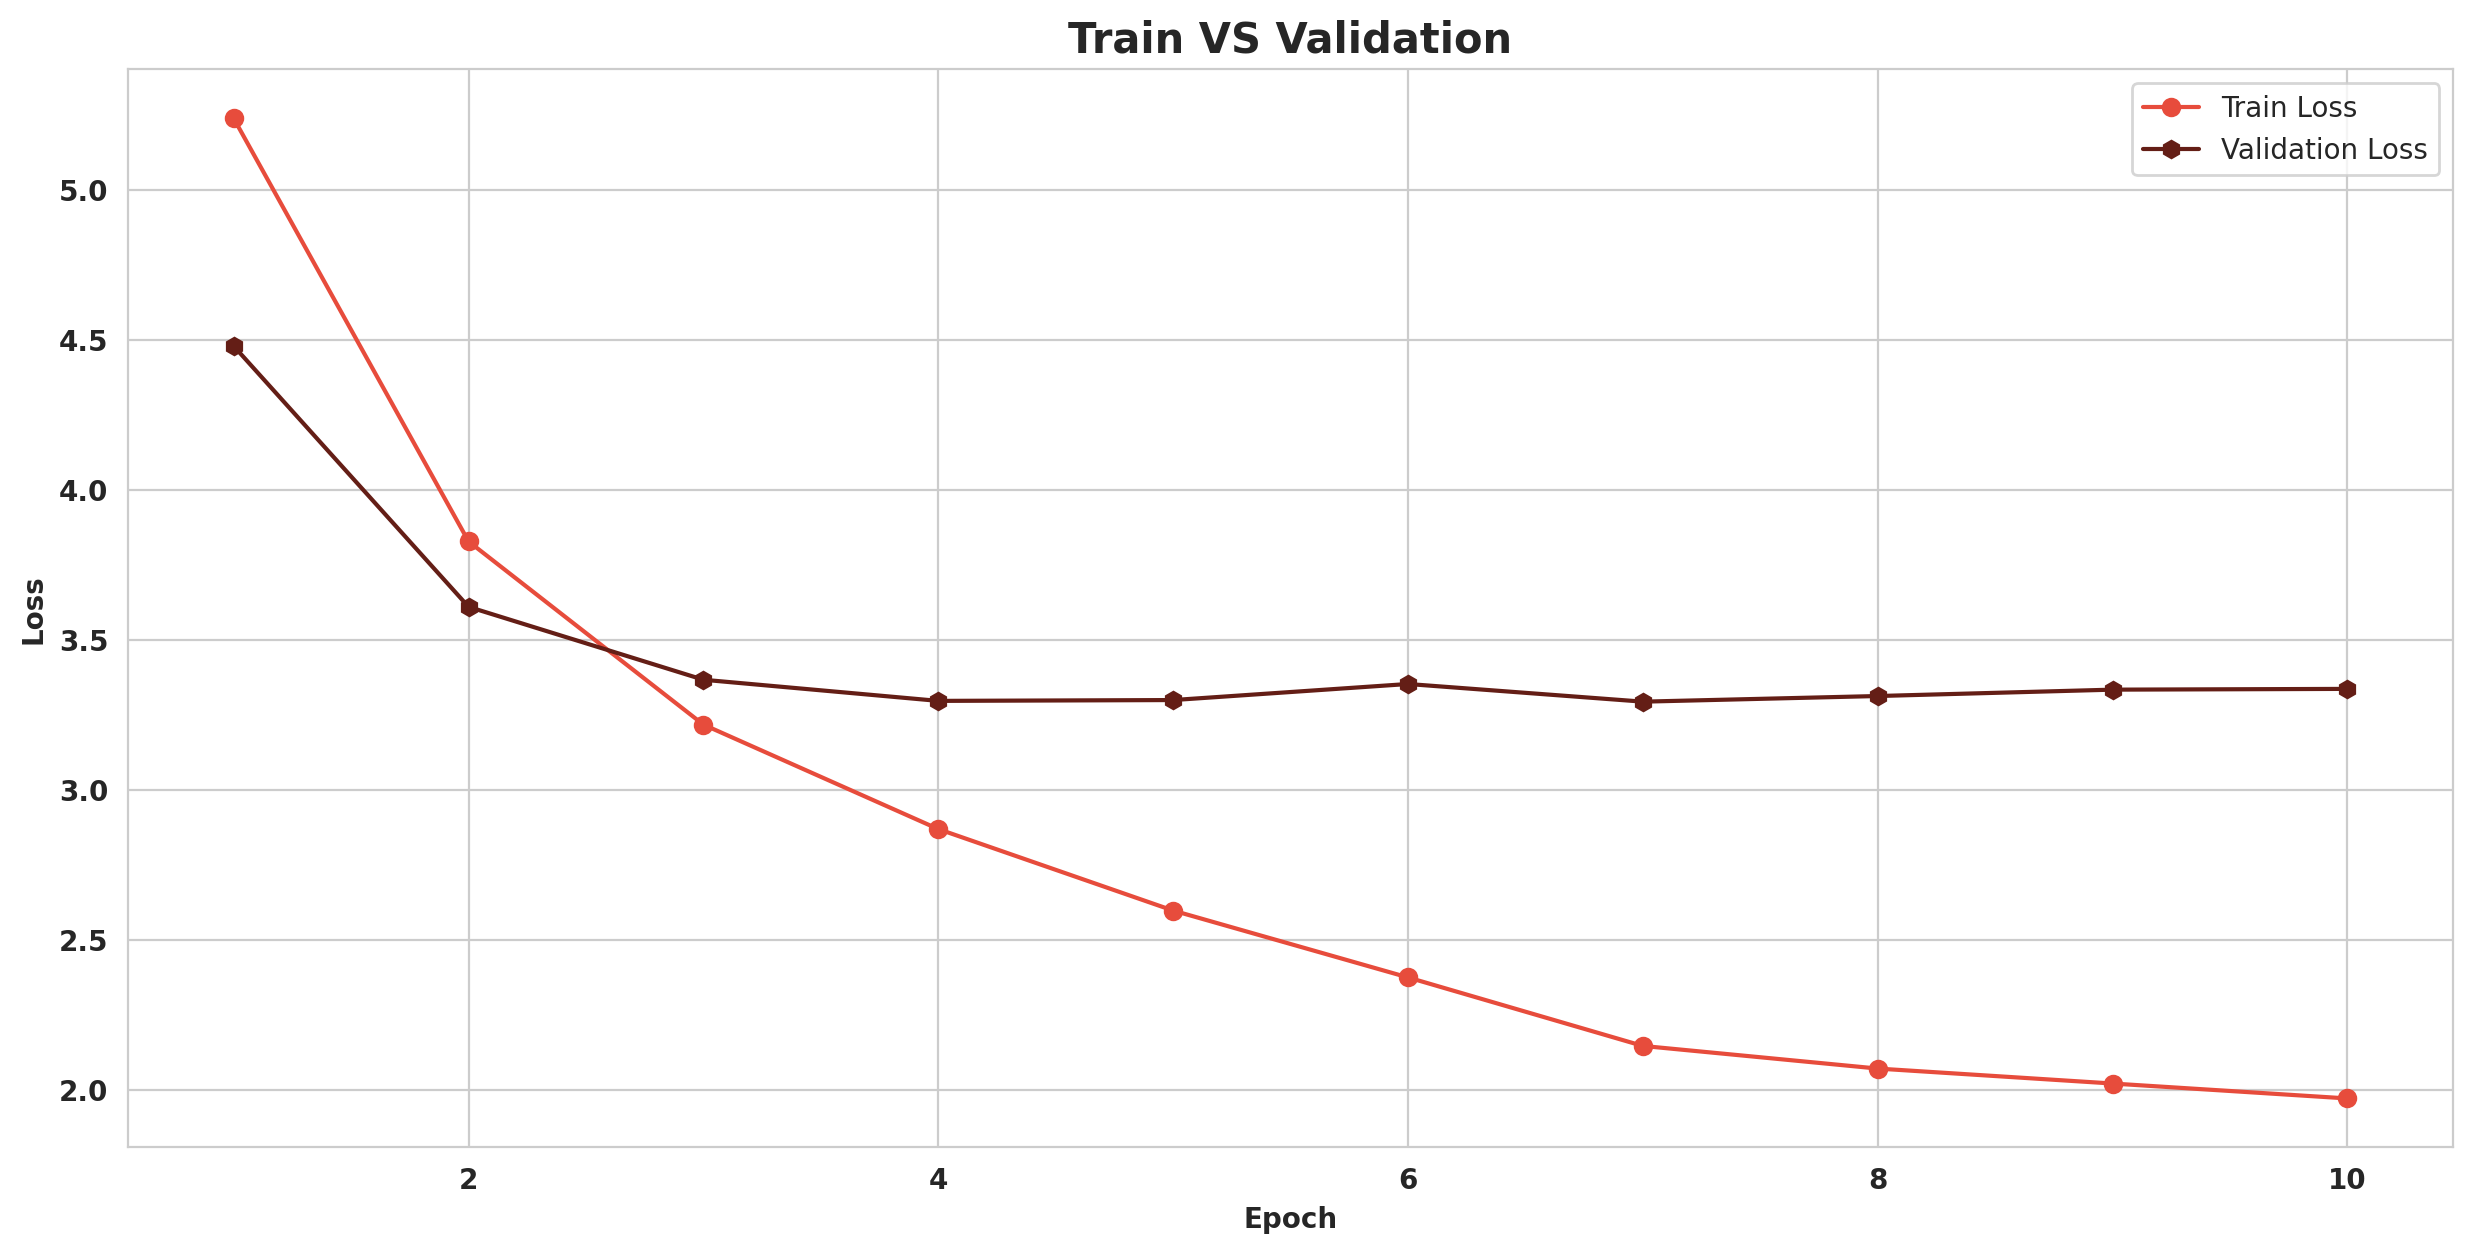

In [ ]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(gru_history.history['loss']))], gru_history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(gru_history.history['loss']))], gru_history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

## Prediction and Model Evaluation - GRU

In [ ]:
def greedy_generator_gru(image_features):
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = gru_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        in_text += ' ' + word
        if word == 'end':
            break
    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')
    return in_text

def beam_search_generator_gru(image_features, K_beams=3, log=False):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]

    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1,max_caption_length))
            preds = gru_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w])
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-K_beams:]

    start_word = start_word[-1][0]
    captions_ = [tokenizer.index_word[i] for i in start_word]
    final_caption = []

    for i in captions_:
        if i != 'end':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

## Visualizing some of the test images along with generated captions - GRU

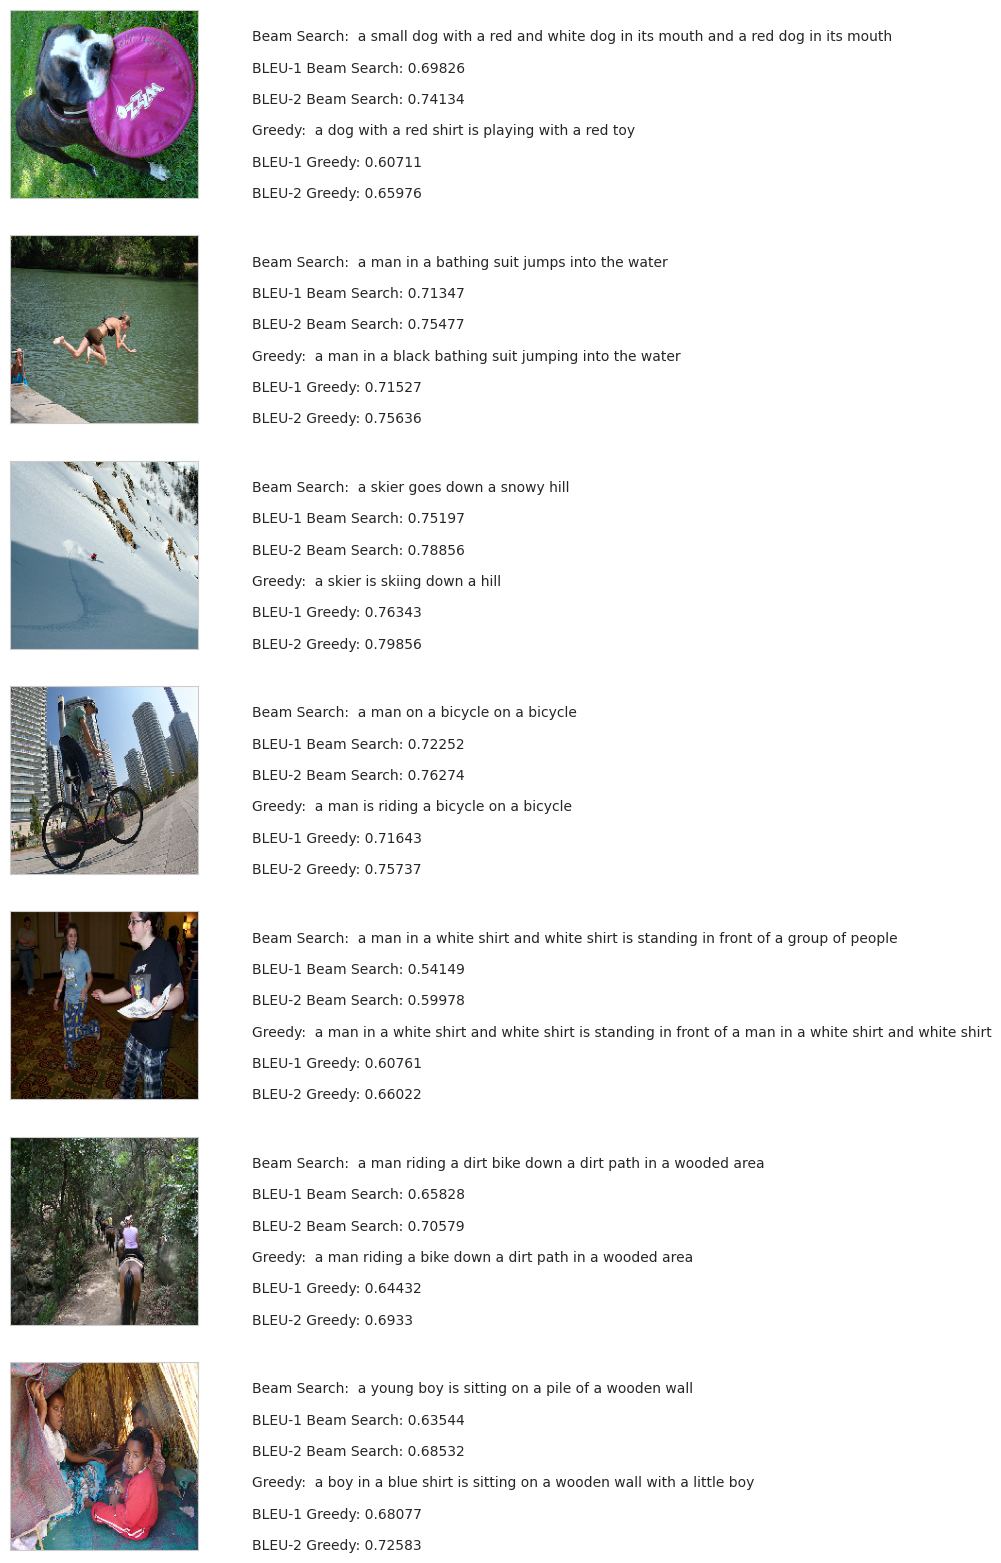

In [ ]:
# Initialize dictionaries for GRU model captions
gru_generated_captions = {}

# Create test_actual_captions dictionary
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

# Generate captions using GRU model
for image_id in test_image_features:
    cap = greedy_generator_gru(test_image_features[image_id])
    gru_generated_captions[image_id] = cap

# Evaluate GRU model using visualization function
visualization(test_actual_captions, gru_generated_captions, beam_search_generator_gru, BLEU_score, 7)

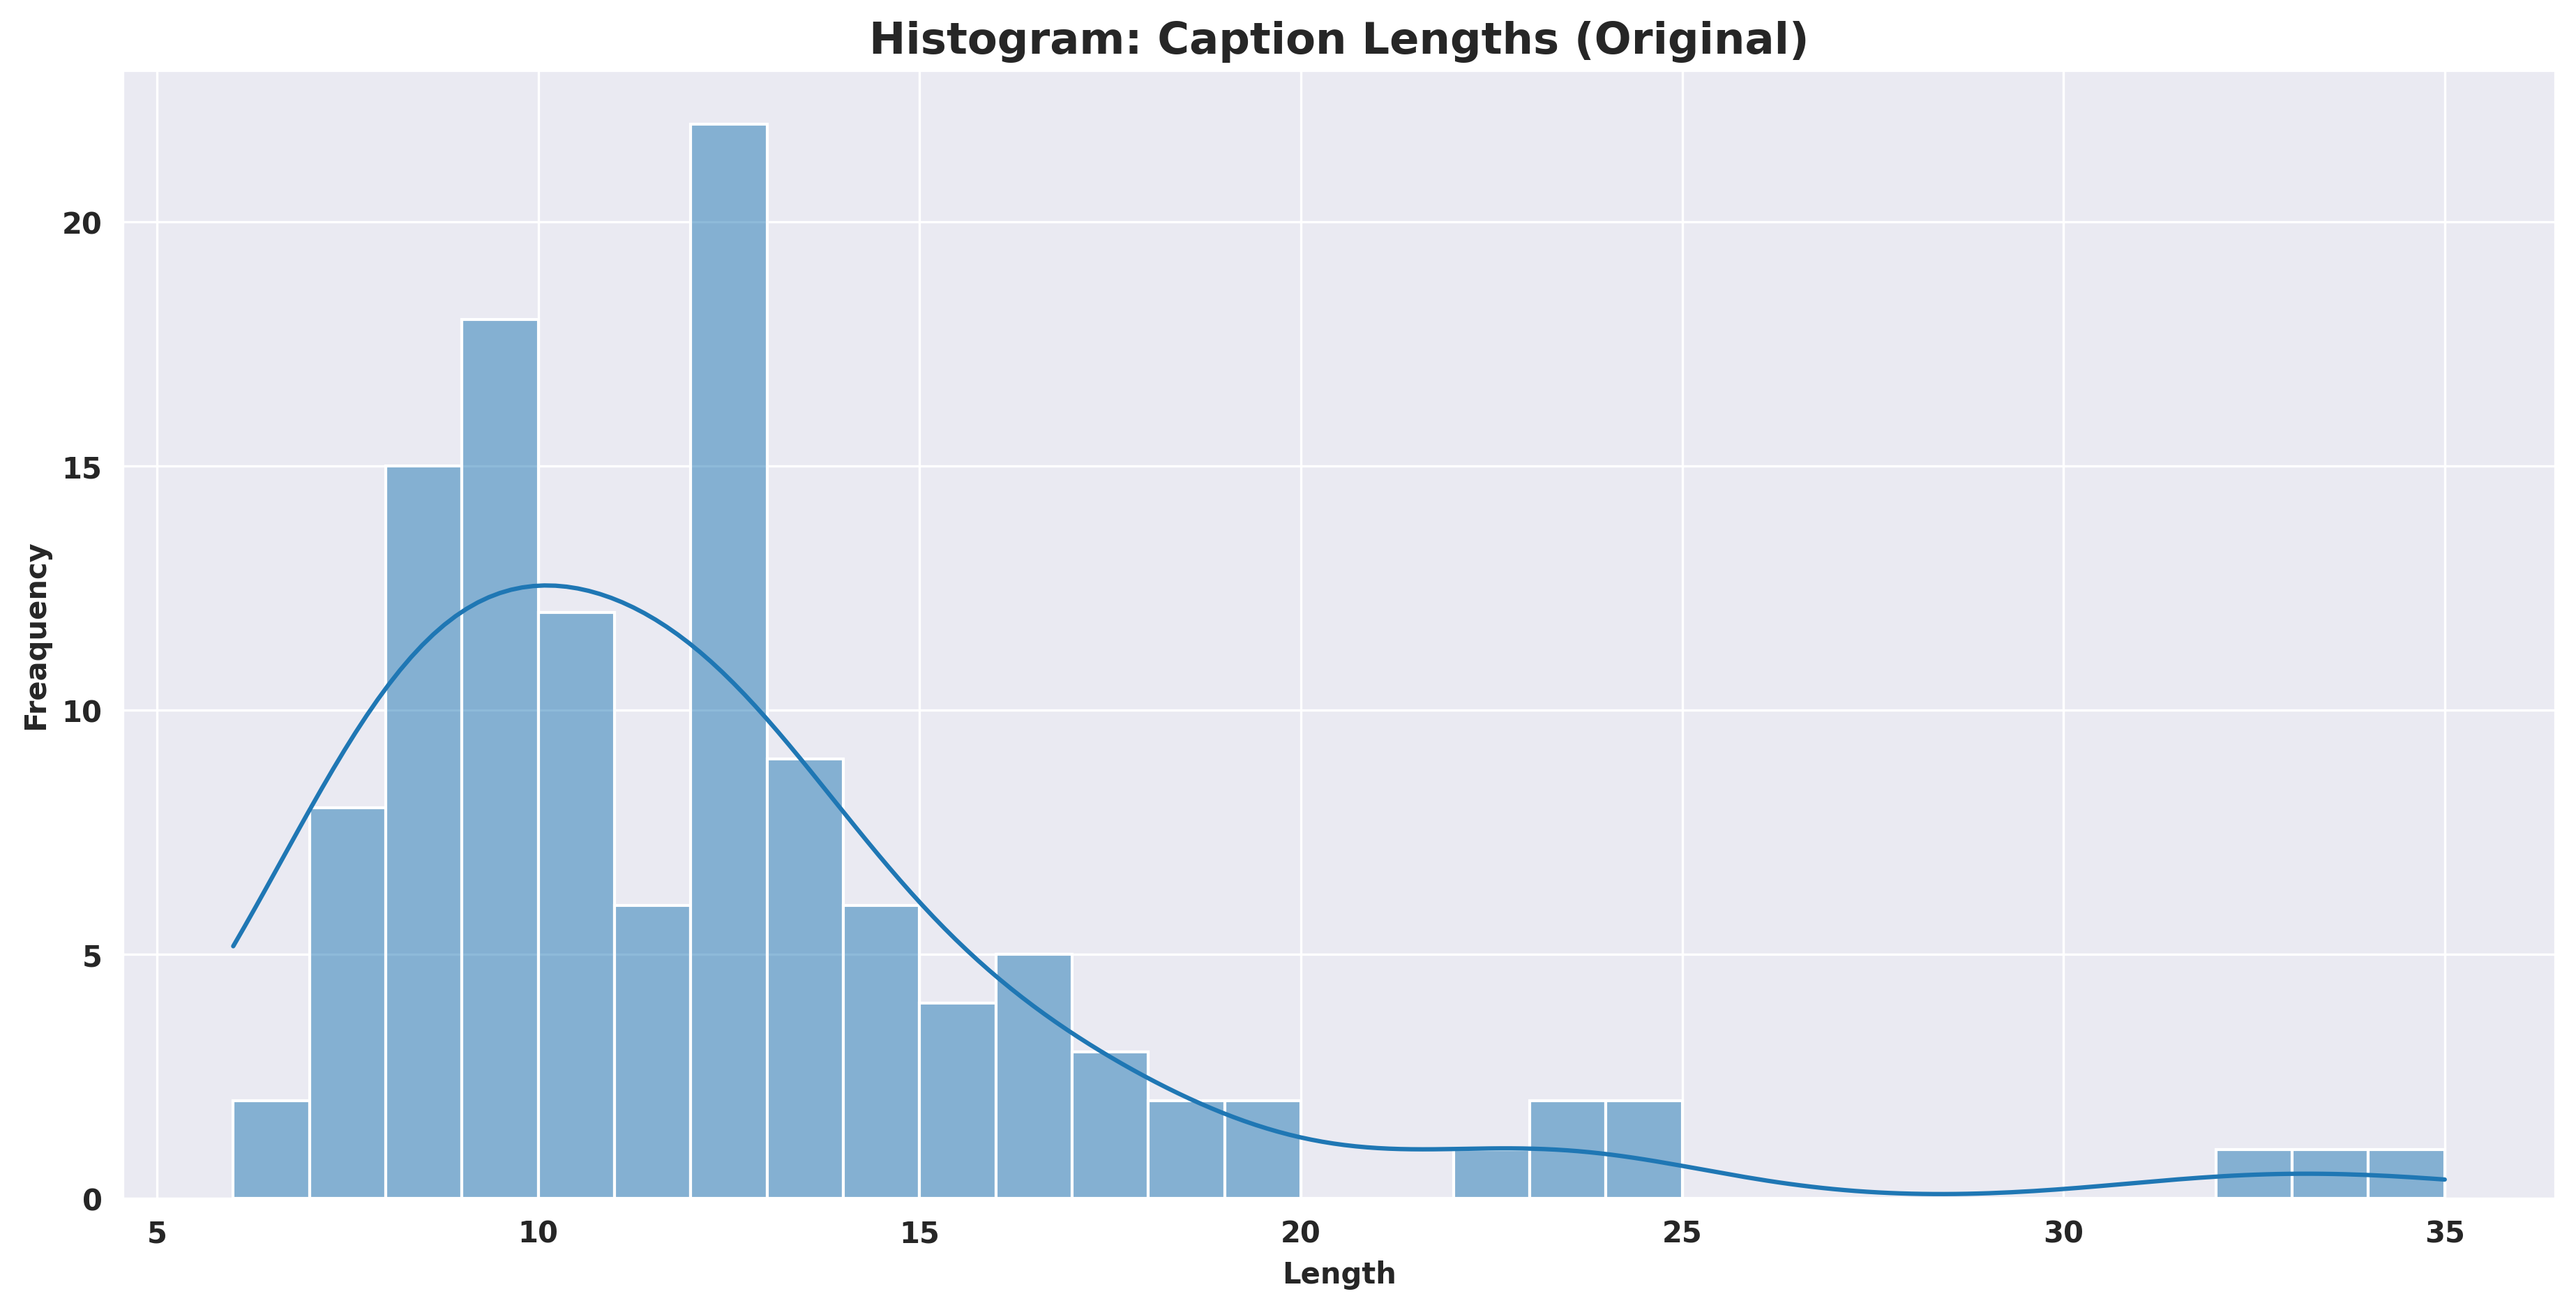

In [ ]:
captions_length(list(gru_generated_captions.values()))